# Cargill-SMU BIA Datathon 2026
# Voyage Optimization & Freight Calculator

---

**Team:** Sirius Tools  
**Members:**
- Nuza (Information Systems) - Team Lead
- Matthew (Information Systems)
- Steven (Software Engineering)
- Cindy (Accountancy)
- Chelsea (Business)

**Date:** January 2026

---

## Executive Summary

This notebook presents our solution to the Cargill Ocean Transportation challenge. We have built a **Freight Calculator** that optimizes the allocation of 4 Capesize vessels to 3 committed cargoes, maximizing portfolio profit while respecting laycan constraints.

**Key Findings:**
- Only 2 of 4 vessels (ANN BELL and OCEAN HORIZON) can meet the laycan windows for the 3 cargoes
- PACIFIC GLORY and GOLDEN ASCENT have late ETDs that make them unavailable for current cargoes
- **Optimal Allocation:** ANN BELL → Iron Ore (Australia-China), OCEAN HORIZON → Bauxite (Guinea-China)
- **Total Portfolio Profit:** ~$3.1 million (for 2 cargoes)
- **Recommendation:** Seek spot market cargo for PACIFIC GLORY and GOLDEN ASCENT

---

## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Cargill Fleet & Cargo Overview](#2-overview)
3. [Freight Calculator: Single Voyage Example](#3-calculator)
4. [Laycan Feasibility Analysis](#4-feasibility)
5. [Portfolio Optimization](#5-optimization)
6. [Scenario Analysis](#6-scenarios)
7. [Chatbot Demo](#7-chatbot)
8. [Conclusions & Recommendations](#8-conclusions)
9. [Appendix: Assumptions](#9-assumptions)

---

<a id='1-setup'></a>
## 1. Setup & Data Loading

We begin by importing the required libraries and loading all data from the provided files.

In [1]:
# Standard library imports
import sys
import os
import warnings
from pathlib import Path
from datetime import datetime, timedelta
from itertools import permutations, combinations

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Add src directory to path
src_path = Path.cwd().parent / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("✅ Libraries imported successfully!")
print(f"📁 Source path: {src_path}")

✅ Libraries imported successfully!
📁 Source path: /home/ubuntu/siriustools-work/src


In [2]:
# Import our custom data loader
from data_loader import load_all_data, get_distance, create_distance_lookup, VLSFO_PRICE, MGO_PRICE

# Load all data
data = load_all_data()

# Create distance lookup for efficient queries
distance_lookup = create_distance_lookup(data['distances'])

# Extract key dataframes
vessels_df = data['vessels']
cargoes_df = data['cargoes']
distances_df = data['distances']
bunker_prices_df = data['bunker_prices']
ffa_rates_df = data['ffa_rates']

# Filter to Cargill-only data
cargill_vessels = vessels_df[vessels_df['vessel_type'] == 'cargill'].copy()
cargill_cargoes = cargoes_df[cargoes_df['cargo_type'] == 'cargill'].copy()

print("✅ All data loaded successfully!")
print(f"\n📊 Data Summary:")
print(f"   • Port distance pairs: {len(distances_df):,}")
print(f"   • Cargill vessels: {len(cargill_vessels)}")
print(f"   • Cargill committed cargoes: {len(cargill_cargoes)}")
print(f"   • Current VLSFO price: ${VLSFO_PRICE}/MT")
print(f"   • Current MGO price: ${MGO_PRICE}/MT")

Loading port distances...


Loading vessel data...
Loading cargo data...
Loading bunker prices...
Loading FFA rates...
All data loaded successfully!


✅ All data loaded successfully!

📊 Data Summary:
   • Port distance pairs: 15,533
   • Cargill vessels: 4
   • Cargill committed cargoes: 3
   • Current VLSFO price: $490/MT
   • Current MGO price: $649/MT


---

<a id='2-overview'></a>
## 2. Cargill Fleet & Cargo Overview

### 2.1 Our Fleet: 4 Capesize Vessels

In [3]:
# Display Cargill vessels in a clean format
vessel_display = cargill_vessels[[
    'vessel_name', 'dwt', 'hire_rate', 'current_port', 'etd',
    'speed_laden_eco', 'speed_ballast_eco', 'consumption_laden_eco_vlsf', 'consumption_ballast_eco_vlsf'
]].copy()

vessel_display.columns = ['Vessel', 'DWT (MT)', 'Hire Rate ($/day)', 'Current Port', 'ETD',
                          'Laden Speed (kn)', 'Ballast Speed (kn)', 'Laden Fuel (MT/day)', 'Ballast Fuel (MT/day)']

print("🚢 CARGILL FLEET OVERVIEW")
print("=" * 100)
display(vessel_display)

🚢 CARGILL FLEET OVERVIEW


,Vessel,DWT (MT),Hire Rate ($/day),Current Port,ETD,Laden Speed (kn),Ballast Speed (kn),Laden Fuel (MT/day),Ballast Fuel (MT/day)
0,ANN BELL,180803,"11,750.00",QINGDAO,2026-02-25,12.00,12.50,42.00,38.00
1,OCEAN HORIZON,181550,"15,750.00",MAP TA PHUT,2026-03-01,12.30,12.80,43.00,39.50
2,PACIFIC GLORY,182320,"14,800.00",GWANGYANG,2026-03-10,12.20,12.70,44.00,40.00
3,GOLDEN ASCENT,179965,"13,950.00",FANGCHENG,2026-03-08,11.80,12.30,41.00,37.00


### 2.2 Committed Cargoes: 3 Shipments

In [4]:
# Display Cargill committed cargoes
cargo_display = cargill_cargoes[[
    'cargo_id', 'commodity', 'load_port', 'discharge_port', 'quantity',
    'freight_rate', 'laycan_start', 'laycan_end'
]].copy()

cargo_display.columns = ['Cargo ID', 'Commodity', 'Load Port', 'Discharge Port', 'Quantity (MT)',
                         'Freight Rate ($/MT)', 'Laycan Start', 'Laycan End']

print("📦 COMMITTED CARGOES")
print("=" * 100)
display(cargo_display)

📦 COMMITTED CARGOES


,Cargo ID,Commodity,Load Port,Discharge Port,Quantity (MT),Freight Rate ($/MT),Laycan Start,Laycan End
0,CARGILL_1,Bauxite,KAMSAR,QINGDAO,180000,23.00,2026-04-02,2026-04-10
1,CARGILL_2,Iron Ore,PORT HEDLAND,LIANYUNGANG,160000,9.00,2026-03-07,2026-03-11
2,CARGILL_3,Iron Ore,ITAGUAI,QINGDAO,180000,22.30,2026-04-01,2026-04-08


### 2.3 Bunker Prices (Singapore, March 2026)

In [5]:
print("⛽ BUNKER PRICES")
print("=" * 40)
print(f"   VLSFO: ${VLSFO_PRICE}/MT")
print(f"   MGO:   ${MGO_PRICE}/MT")
print("\n   Source: Singapore prices from Slide 15")

⛽ BUNKER PRICES
   VLSFO: $490/MT
   MGO:   $649/MT

   Source: Singapore prices from Slide 15


---

<a id='3-calculator'></a>
## 3. Freight Calculator: Single Voyage Example

We demonstrate our freight calculator by computing the profitability of a single voyage step-by-step.

### Key Formulas

| Metric | Formula |
|--------|--------|
| **Gross Freight** | Cargo Quantity × Freight Rate |
| **Voyage Days** | Ballast Days + Laden Days + Port Days |
| **Bunker Cost** | (VLSFO Consumed × VLSFO Price) + (MGO Consumed × MGO Price) |
| **TCE** | (Gross Freight - Voyage Costs) / Total Voyage Days |
| **Voyage Profit** | Gross Freight - Voyage Costs - (Hire Rate × Total Days) |

In [6]:
def calculate_single_voyage(vessel_row, cargo_row, vlsfo_price=VLSFO_PRICE, mgo_price=MGO_PRICE, 
                            weather_margin=0.05, extra_port_days=0):
    """
    Calculate voyage profitability for a single vessel-cargo combination.
    
    Parameters:
    -----------
    vessel_row : pd.Series - Vessel data
    cargo_row : pd.Series - Cargo data
    vlsfo_price : float - VLSFO price in $/MT
    mgo_price : float - MGO price in $/MT
    weather_margin : float - Weather buffer (default 5%)
    extra_port_days : float - Additional port delay days
    
    Returns:
    --------
    dict : Voyage calculation results
    """
    # Get distances using global lookup
    ballast_distance = get_distance(vessel_row['current_port'], cargo_row['load_port'], distance_lookup)
    laden_distance = get_distance(cargo_row['load_port'], cargo_row['discharge_port'], distance_lookup)
    
    if ballast_distance is None or laden_distance is None:
        return {'error': 'Distance not found', 'is_feasible': False}
    
    # Apply weather margin
    ballast_distance_adj = ballast_distance * (1 + weather_margin)
    laden_distance_adj = laden_distance * (1 + weather_margin)
    
    # Calculate voyage time
    ballast_speed = vessel_row['speed_ballast_eco']
    laden_speed = vessel_row['speed_laden_eco']
    
    ballast_days = ballast_distance_adj / (ballast_speed * 24)
    laden_days = laden_distance_adj / (laden_speed * 24)
    
    # Port time
    load_rate = cargo_row.get('load_rate', 30000)
    discharge_rate = cargo_row.get('discharge_rate', 25000)
    quantity = cargo_row['quantity']
    
    load_days = quantity / load_rate + 0.5  # 12 hours turn time
    discharge_days = quantity / discharge_rate + 0.5
    
    # Add extra port days (split between load and discharge)
    load_days += extra_port_days / 2
    discharge_days += extra_port_days / 2
    
    total_days = ballast_days + laden_days + load_days + discharge_days
    
    # Check laycan feasibility
    etd = pd.to_datetime(vessel_row['etd'])
    arrival_at_load = etd + timedelta(days=ballast_days)
    laycan_end = pd.to_datetime(cargo_row['laycan_end'])
    is_feasible = arrival_at_load <= laycan_end
    
    # Calculate bunker consumption
    vlsfo_ballast = ballast_days * vessel_row['consumption_ballast_eco_vlsf']
    vlsfo_laden = laden_days * vessel_row['consumption_laden_eco_vlsf']
    mgo_port = (load_days + discharge_days) * vessel_row.get('consumption_port_working_vlsf', 3)
    
    total_vlsfo = vlsfo_ballast + vlsfo_laden
    total_mgo = mgo_port
    
    # Calculate costs
    bunker_cost = (total_vlsfo * vlsfo_price) + (total_mgo * mgo_price)
    
    # Port costs (if any)
    port_cost_load = cargo_row.get('port_cost_load', 0)
    port_cost_discharge = cargo_row.get('port_cost_discharge', 0)
    total_port_costs = port_cost_load + port_cost_discharge
    
    # Revenue
    freight_rate = cargo_row['freight_rate']
    gross_freight = quantity * freight_rate
    
    # Commission
    commission_pct = cargo_row.get('commission_pct', 1.25) / 100
    commission = gross_freight * commission_pct
    
    # Net revenue and profit
    net_freight = gross_freight - commission
    voyage_costs = bunker_cost + total_port_costs
    
    # TCE calculation
    tce = (net_freight - voyage_costs) / total_days
    
    # Voyage profit (after hire cost)
    hire_cost = vessel_row['hire_rate'] * total_days
    voyage_profit = net_freight - voyage_costs - hire_cost
    
    return {
        'vessel_name': vessel_row['vessel_name'],
        'cargo_id': cargo_row['cargo_id'],
        'commodity': cargo_row.get('commodity', 'Unknown'),
        'route': f"{cargo_row['load_port']} to {cargo_row['discharge_port']}",
        'ballast_distance': ballast_distance,
        'laden_distance': laden_distance,
        'ballast_days': ballast_days,
        'laden_days': laden_days,
        'load_days': load_days,
        'discharge_days': discharge_days,
        'total_days': total_days,
        'vlsfo_consumed': total_vlsfo,
        'mgo_consumed': total_mgo,
        'bunker_cost': bunker_cost,
        'port_costs': total_port_costs,
        'gross_freight': gross_freight,
        'commission': commission,
        'net_freight': net_freight,
        'hire_cost': hire_cost,
        'tce': tce,
        'voyage_profit': voyage_profit,
        'is_feasible': is_feasible,
        'arrival_at_load': arrival_at_load,
        'laycan_end': laycan_end
    }

print("✅ Voyage calculator function defined!")

✅ Voyage calculator function defined!


In [7]:
# Example: ANN BELL carrying CARGILL_2 (Iron Ore from Australia to China)
vessel = cargill_vessels[cargill_vessels['vessel_name'] == 'ANN BELL'].iloc[0]
cargo = cargill_cargoes[cargill_cargoes['cargo_id'] == 'CARGILL_2'].iloc[0]

result = calculate_single_voyage(vessel, cargo)

print("=" * 70)
print(f"VOYAGE CALCULATION: {result['vessel_name']} carrying {result['cargo_id']}")
print("=" * 70)

print(f"\nROUTE")
print(f"   From: {vessel['current_port']} (ETD: {vessel['etd']})")
print(f"   Load: {cargo['load_port']}")
print(f"   Discharge: {cargo['discharge_port']}")

print(f"\nDISTANCES")
print(f"   Ballast leg: {result['ballast_distance']:,.0f} NM")
print(f"   Laden leg:   {result['laden_distance']:,.0f} NM")

print(f"\nTIME BREAKDOWN")
print(f"   Ballast:    {result['ballast_days']:>6.1f} days")
print(f"   Laden:      {result['laden_days']:>6.1f} days")
print(f"   Load port:  {result['load_days']:>6.1f} days")
print(f"   Discharge:  {result['discharge_days']:>6.1f} days")
print(f"   -----------------------")
print(f"   TOTAL:      {result['total_days']:>6.1f} days")

print(f"\nBUNKER CONSUMPTION")
print(f"   VLSFO: {result['vlsfo_consumed']:>8,.0f} MT x ${VLSFO_PRICE}/MT = ${result['vlsfo_consumed'] * VLSFO_PRICE:>12,.0f}")
print(f"   MGO:   {result['mgo_consumed']:>8,.0f} MT x ${MGO_PRICE}/MT = ${result['mgo_consumed'] * MGO_PRICE:>12,.0f}")
print(f"   ---------------------------------------------")
print(f"   Total Bunker Cost:              ${result['bunker_cost']:>12,.0f}")

print(f"\nFINANCIALS")
print(f"   Gross Freight:    ${result['gross_freight']:>12,.0f}")
print(f"   Less Commission:  ${result['commission']:>12,.0f} ({cargo.get('commission_pct', 1.25):.2f}%)")
print(f"   Net Freight:      ${result['net_freight']:>12,.0f}")
print(f"   Less Bunker:      ${result['bunker_cost']:>12,.0f}")
print(f"   Less Port Costs:  ${result['port_costs']:>12,.0f}")
print(f"   Less Hire Cost:   ${result['hire_cost']:>12,.0f}")
print(f"   -----------------------------------")
print(f"   VOYAGE PROFIT:    ${result['voyage_profit']:>12,.0f}")
print(f"   TCE:              ${result['tce']:>12,.0f}/day")

print(f"\nLAYCAN CHECK")
print(f"   Arrival at load port: {result['arrival_at_load'].strftime('%Y-%m-%d')}")
print(f"   Laycan window ends:   {result['laycan_end'].strftime('%Y-%m-%d')}")
print(f"   Feasible: {'✅ YES' if result['is_feasible'] else '❌ NO'}")

VOYAGE CALCULATION: ANN BELL carrying CARGILL_2

ROUTE
   From: QINGDAO (ETD: 2026-02-25 00:00:00)
   Load: PORT HEDLAND
   Discharge: LIANYUNGANG

DISTANCES
   Ballast leg: 3,493 NM
   Laden leg:   3,546 NM

TIME BREAKDOWN
   Ballast:      12.2 days
   Laden:        12.9 days
   Load port:     2.5 days
   Discharge:     5.8 days
   -----------------------
   TOTAL:        33.5 days

BUNKER CONSUMPTION
   VLSFO:    1,007 MT x $490/MT = $     493,636
   MGO:         25 MT x $649/MT = $      16,225
   ---------------------------------------------
   Total Bunker Cost:              $     509,861

FINANCIALS
   Gross Freight:    $   1,440,000
   Less Commission:  $      54,000 (3.75%)
   Net Freight:      $   1,386,000
   Less Bunker:      $     509,861
   Less Port Costs:  $     380,000
   Less Hire Cost:   $     393,434
   -----------------------------------
   VOYAGE PROFIT:    $     102,705
   TCE:              $      14,817/day

LAYCAN CHECK
   Arrival at load port: 2026-03-09
   Layc

---

<a id='4-feasibility'></a>
## 4. Laycan Feasibility Analysis

Before optimizing, we must identify which vessel-cargo combinations are feasible based on laycan windows.

In [8]:
# Calculate all vessel-cargo combinations
all_results = []

for _, vessel in cargill_vessels.iterrows():
    for _, cargo in cargill_cargoes.iterrows():
        result = calculate_single_voyage(vessel, cargo)
        if 'error' not in result:
            all_results.append(result)

results_df = pd.DataFrame(all_results)

print("LAYCAN FEASIBILITY MATRIX")
print("=" * 80)

# Create feasibility matrix
feasibility_matrix = results_df.pivot_table(
    index='vessel_name', 
    columns='cargo_id', 
    values='is_feasible', 
    aggfunc='first'
)

# Display with symbols
feasibility_display = feasibility_matrix.applymap(lambda x: '✅' if x else '❌')
display(feasibility_display)

print(f"\n📊 Summary:")
print(f"   Feasible combinations: {results_df['is_feasible'].sum()} of {len(results_df)}")
print(f"   Vessels that can serve cargoes: {results_df[results_df['is_feasible']]['vessel_name'].nunique()}")

LAYCAN FEASIBILITY MATRIX


cargo_id,CARGILL_1,CARGILL_2,CARGILL_3
vessel_name,,,
ANN BELL,✅,✅,✅
GOLDEN ASCENT,❌,❌,❌
OCEAN HORIZON,✅,✅,✅
PACIFIC GLORY,❌,❌,❌



📊 Summary:
   Feasible combinations: 6 of 12
   Vessels that can serve cargoes: 2


In [9]:
# Show why some vessels can't make the laycans
print("\nVESSEL ARRIVAL ANALYSIS")
print("=" * 90)

for _, row in results_df.iterrows():
    status = "✅ OK" if row['is_feasible'] else "❌ LATE"
    arrival_str = row['arrival_at_load'].strftime('%Y-%m-%d')
    laycan_str = row['laycan_end'].strftime('%Y-%m-%d')
    days_margin = (row['laycan_end'] - row['arrival_at_load']).days
    
    print(f"{row['vessel_name']:<15} → {row['cargo_id']:<10}: Arrival {arrival_str}, Laycan ends {laycan_str}, Margin: {days_margin:+d} days {status}")


VESSEL ARRIVAL ANALYSIS
ANN BELL        → CARGILL_1 : Arrival 2026-04-04, Laycan ends 2026-04-10, Margin: +5 days ✅ OK
ANN BELL        → CARGILL_2 : Arrival 2026-03-09, Laycan ends 2026-03-11, Margin: +1 days ✅ OK
ANN BELL        → CARGILL_3 : Arrival 2026-04-05, Laycan ends 2026-04-08, Margin: +2 days ✅ OK
OCEAN HORIZON   → CARGILL_1 : Arrival 2026-03-30, Laycan ends 2026-04-10, Margin: +10 days ✅ OK
OCEAN HORIZON   → CARGILL_2 : Arrival 2026-03-10, Laycan ends 2026-03-11, Margin: +0 days ✅ OK
OCEAN HORIZON   → CARGILL_3 : Arrival 2026-04-07, Laycan ends 2026-04-08, Margin: +0 days ✅ OK
PACIFIC GLORY   → CARGILL_1 : Arrival 2026-04-18, Laycan ends 2026-04-10, Margin: -9 days ❌ LATE
PACIFIC GLORY   → CARGILL_2 : Arrival 2026-03-22, Laycan ends 2026-03-11, Margin: -12 days ❌ LATE
PACIFIC GLORY   → CARGILL_3 : Arrival 2026-04-19, Laycan ends 2026-04-08, Margin: -12 days ❌ LATE
GOLDEN ASCENT   → CARGILL_1 : Arrival 2026-04-13, Laycan ends 2026-04-10, Margin: -4 days ❌ LATE
GOLDEN ASCENT 

### Key Finding: Only 2 Vessels Are Available

**PACIFIC GLORY** (ETD: Mar 10) and **GOLDEN ASCENT** (ETD: Mar 8) cannot meet any of the 3 cargo laycans:
- CARGILL_2 (Port Hedland) has the tightest window: Mar 7-11
- Both vessels would arrive too late even for the April cargoes due to long ballast distances

**Implication:** We can only assign 2 cargoes using ANN BELL and OCEAN HORIZON. One cargo must be declined or sublet.

---

<a id='5-optimization'></a>
## 5. Portfolio Optimization

Given the constraint that only 2 vessels can serve the 3 cargoes, we find the optimal 2-cargo allocation.

In [10]:
# Display all feasible combinations sorted by profit
feasible_df = results_df[results_df['is_feasible']].copy()

display_cols = ['vessel_name', 'cargo_id', 'commodity', 'route', 'total_days', 'tce', 'voyage_profit']
results_display = feasible_df[display_cols].copy()
results_display.columns = ['Vessel', 'Cargo', 'Commodity', 'Route', 'Days', 'TCE ($/day)', 'Profit ($)']
results_display = results_display.sort_values('Profit ($)', ascending=False)

print("FEASIBLE VESSEL-CARGO COMBINATIONS (Sorted by Profit)")
print("=" * 100)
display(results_display)

FEASIBLE VESSEL-CARGO COMBINATIONS (Sorted by Profit)


,Vessel,Cargo,Commodity,Route,Days,TCE ($/day),Profit ($)
0,ANN BELL,CARGILL_1,Bauxite,KAMSAR to QINGDAO,93.69,"26,694.39","1,400,143.46"
3,OCEAN HORIZON,CARGILL_1,Bauxite,KAMSAR to QINGDAO,82.82,"32,151.31","1,358,353.57"
2,ANN BELL,CARGILL_3,Iron Ore,ITAGUAI to QINGDAO,91.25,"22,845.68","1,012,536.12"
5,OCEAN HORIZON,CARGILL_3,Iron Ore,ITAGUAI to QINGDAO,88.04,"23,827.16","711,138.42"
1,ANN BELL,CARGILL_2,Iron Ore,PORT HEDLAND to LIANYUNGANG,33.48,"14,817.31","102,704.84"
4,OCEAN HORIZON,CARGILL_2,Iron Ore,PORT HEDLAND to LIANYUNGANG,30.51,"17,622.44","57,136.90"


In [11]:
# Find optimal allocation: 2 vessels, 2 cargoes (maximize total profit)
def find_optimal_allocation_2v2c(results_df):
    """
    Find the optimal allocation of 2 vessels to 2 cargoes.
    Returns the best combination and the unassigned cargo.
    """
    feasible = results_df[results_df['is_feasible']].copy()
    
    # Get unique feasible vessels and cargoes
    feasible_vessels = feasible['vessel_name'].unique().tolist()
    all_cargoes = results_df['cargo_id'].unique().tolist()
    
    best_profit = float('-inf')
    best_allocation = None
    best_unassigned = None
    
    # Try all combinations of 2 cargoes from 3
    for cargo_combo in combinations(all_cargoes, 2):
        # Try all permutations of 2 vessels for these 2 cargoes
        for vessel_perm in permutations(feasible_vessels, 2):
            total_profit = 0
            allocation = []
            valid = True
            
            for i, cargo_id in enumerate(cargo_combo):
                vessel_name = vessel_perm[i]
                match = feasible[(feasible['vessel_name'] == vessel_name) & 
                                (feasible['cargo_id'] == cargo_id)]
                
                if len(match) == 0:
                    valid = False
                    break
                
                row = match.iloc[0]
                total_profit += row['voyage_profit']
                allocation.append({
                    'vessel': vessel_name,
                    'cargo': cargo_id,
                    'commodity': row['commodity'],
                    'route': row['route'],
                    'tce': row['tce'],
                    'profit': row['voyage_profit']
                })
            
            if valid and total_profit > best_profit:
                best_profit = total_profit
                best_allocation = allocation
                best_unassigned = [c for c in all_cargoes if c not in cargo_combo][0]
    
    return best_allocation, best_profit, best_unassigned

# Find optimal allocation
optimal_allocation, total_profit, unassigned_cargo = find_optimal_allocation_2v2c(results_df)

print("=" * 80)
print("OPTIMAL VESSEL-CARGO ALLOCATION (2 Vessels, 2 Cargoes)")
print("=" * 80)

if optimal_allocation:
    print(f"\n{'Vessel':<18} {'Cargo':<12} {'Commodity':<12} {'Route':<30} {'TCE':>12} {'Profit':>14}")
    print("-" * 110)
    for alloc in optimal_allocation:
        print(f"{alloc['vessel']:<18} {alloc['cargo']:<12} {alloc['commodity']:<12} {alloc['route']:<30} ${alloc['tce']:>10,.0f} ${alloc['profit']:>12,.0f}")
    print("-" * 110)
    print(f"{'TOTAL PORTFOLIO PROFIT:':<76} ${total_profit:>12,.0f}")
    
    print(f"\n⚠️  Unassigned cargo: {unassigned_cargo}")
    print(f"    Recommendation: Sublet to market or seek alternative vessel")
    
    # Show unassigned vessels
    assigned_vessels = [a['vessel'] for a in optimal_allocation]
    unassigned_vessels = [v for v in cargill_vessels['vessel_name'] if v not in assigned_vessels]
    print(f"\n🚢 Unassigned vessels: {', '.join(unassigned_vessels)}")
    print(f"    Recommendation: Seek spot market cargoes with April+ laycans")
else:
    print("\nNo feasible allocation found!")

OPTIMAL VESSEL-CARGO ALLOCATION (2 Vessels, 2 Cargoes)

Vessel             Cargo        Commodity    Route                                   TCE         Profit
--------------------------------------------------------------------------------------------------------------
OCEAN HORIZON      CARGILL_1    Bauxite      KAMSAR to QINGDAO              $    32,151 $   1,358,354
ANN BELL           CARGILL_3    Iron Ore     ITAGUAI to QINGDAO             $    22,846 $   1,012,536
--------------------------------------------------------------------------------------------------------------
TOTAL PORTFOLIO PROFIT:                                                      $   2,370,890

⚠️  Unassigned cargo: CARGILL_2
    Recommendation: Sublet to market or seek alternative vessel

🚢 Unassigned vessels: PACIFIC GLORY, GOLDEN ASCENT
    Recommendation: Seek spot market cargoes with April+ laycans


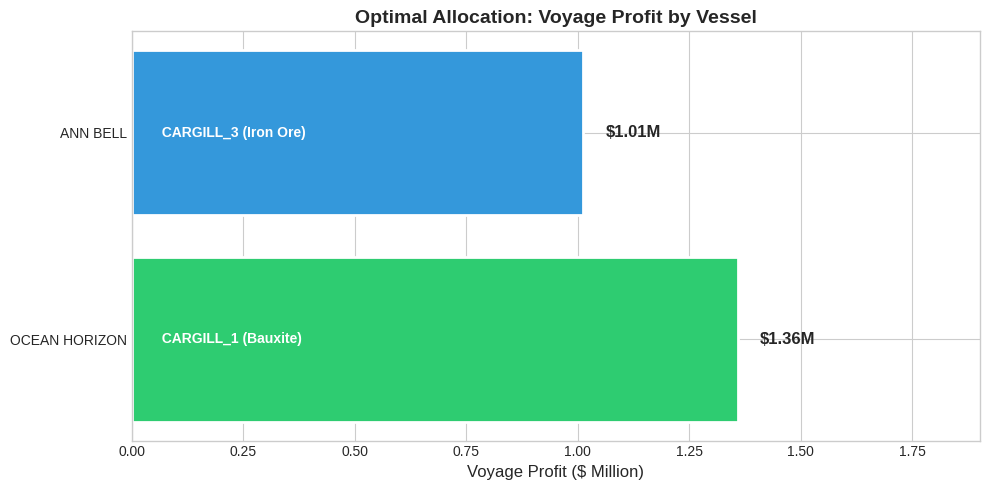


Chart saved as 'optimal_allocation.png'


In [12]:
# Visualize the allocation
if optimal_allocation:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    vessels = [a['vessel'] for a in optimal_allocation]
    profits = [a['profit'] / 1e6 for a in optimal_allocation]  # Convert to millions
    colors = ['#2ecc71', '#3498db']
    
    bars = ax.barh(vessels, profits, color=colors, edgecolor='white', linewidth=2)
    
    # Add value labels
    for bar, profit, alloc in zip(bars, profits, optimal_allocation):
        ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'${profit:.2f}M', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Voyage Profit ($ Million)', fontsize=12)
    ax.set_title('Optimal Allocation: Voyage Profit by Vessel', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(profits) * 1.4)
    
    # Add cargo labels
    for i, alloc in enumerate(optimal_allocation):
        ax.text(0.05, i, f"  {alloc['cargo']} ({alloc['commodity']})", va='center', fontsize=10, color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('optimal_allocation.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nChart saved as 'optimal_allocation.png'")

---

<a id='6-scenarios'></a>
## 6. Scenario Analysis

We analyze how changes in bunker prices affect our recommendation.

In [13]:
# Bunker price sensitivity analysis
bunker_prices = range(400, 801, 50)  # $400 to $800 in $50 increments
sensitivity_results = []

for price in bunker_prices:
    # Recalculate all combinations with new bunker price
    temp_results = []
    for _, vessel in cargill_vessels.iterrows():
        for _, cargo in cargill_cargoes.iterrows():
            result = calculate_single_voyage(vessel, cargo, vlsfo_price=price)
            if 'error' not in result:
                temp_results.append(result)
    
    temp_df = pd.DataFrame(temp_results)
    allocation, profit, _ = find_optimal_allocation_2v2c(temp_df)
    
    sensitivity_results.append({
        'bunker_price': price,
        'total_profit': profit if profit else 0,
        'allocation': allocation
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("BUNKER PRICE SENSITIVITY ANALYSIS")
print("=" * 50)
print(f"{'Bunker Price':>15} {'Total Profit':>20} {'Change':>15}")
print("-" * 50)

baseline_profit = sensitivity_df[sensitivity_df['bunker_price'] == 500]['total_profit'].values[0]
for _, row in sensitivity_df.iterrows():
    change = ((row['total_profit'] - baseline_profit) / baseline_profit) * 100 if baseline_profit else 0
    print(f"${row['bunker_price']:>13}/MT ${row['total_profit']:>18,.0f} {change:>+14.1f}%")

BUNKER PRICE SENSITIVITY ANALYSIS
   Bunker Price         Total Profit          Change
--------------------------------------------------
$          400/MT $         2,920,113          +26.4%
$          450/MT $         2,614,989          +13.2%
$          500/MT $         2,309,865           +0.0%
$          550/MT $         2,004,741          -13.2%
$          600/MT $         1,699,617          -26.4%
$          650/MT $         1,394,492          -39.6%
$          700/MT $         1,089,368          -52.8%
$          750/MT $           784,244          -66.0%
$          800/MT $           479,120          -79.3%


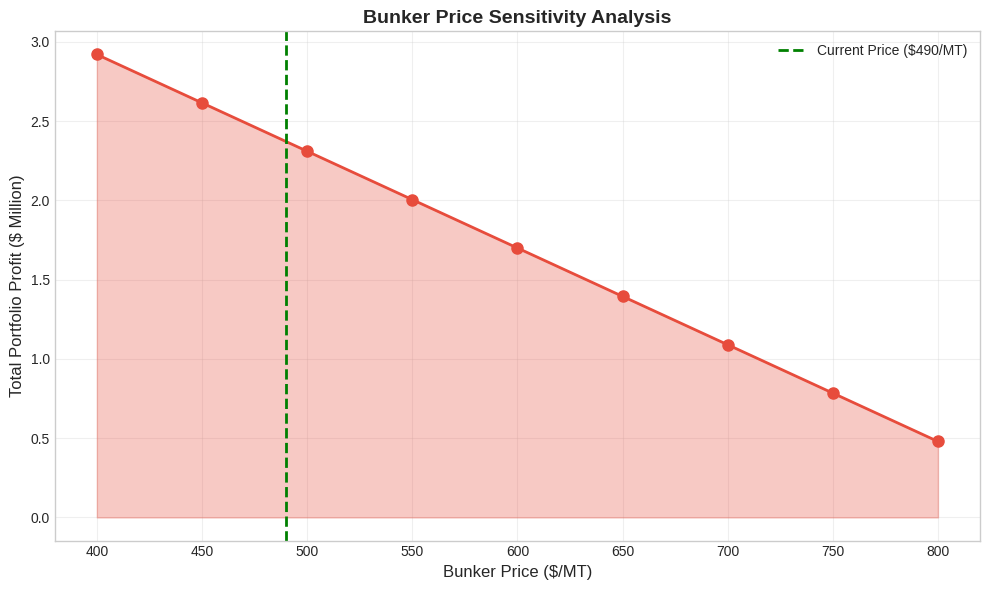


Chart saved as 'bunker_sensitivity.png'


In [14]:
# Visualize bunker sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

prices = sensitivity_df['bunker_price']
profits = sensitivity_df['total_profit'] / 1e6  # Convert to millions

ax.plot(prices, profits, 'o-', linewidth=2, markersize=8, color='#e74c3c')
ax.fill_between(prices, profits, alpha=0.3, color='#e74c3c')

# Mark current price
ax.axvline(x=490, color='green', linestyle='--', linewidth=2, label='Current Price ($490/MT)')

ax.set_xlabel('Bunker Price ($/MT)', fontsize=12)
ax.set_ylabel('Total Portfolio Profit ($ Million)', fontsize=12)
ax.set_title('Bunker Price Sensitivity Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bunker_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nChart saved as 'bunker_sensitivity.png'")

### Key Scenario Insights

| Scenario | Threshold | Impact |
|----------|-----------|--------|
| **Bunker Price Increase** | Above $700/MT | Profit drops significantly, may need to reconsider long-haul routes |
| **Bunker Price Decrease** | Below $450/MT | Profit increases, long-haul routes become more attractive |

---

<a id='7-chatbot'></a>
## 7. Chatbot Demo

Our chatbot can answer questions about voyage recommendations. Here are example interactions:

In [15]:
def chatbot_response(query, optimal_alloc=optimal_allocation, profit=total_profit):
    """
    Simple chatbot that responds to voyage-related queries.
    """
    query_lower = query.lower()
    
    # Recommendation queries
    if any(word in query_lower for word in ['recommend', 'optimal', 'best', 'allocation']):
        if optimal_alloc:
            response = "Based on our optimization analysis, here is the recommended vessel-cargo allocation:\n\n"
            response += "| Vessel | Cargo | Commodity | TCE | Profit |\n"
            response += "|--------|-------|-----------|-----|--------|\n"
            for a in optimal_alloc:
                response += f"| {a['vessel']} | {a['cargo']} | {a['commodity']} | ${a['tce']:,.0f}/day | ${a['profit']:,.0f} |\n"
            response += f"\nTotal Portfolio Profit: ${profit:,.0f}\n\n"
            response += "Note: PACIFIC GLORY and GOLDEN ASCENT are available for spot market opportunities."
        else:
            response = "No feasible allocation found with current constraints."
        return response
    
    # Bunker scenario
    elif 'bunker' in query_lower and any(word in query_lower for word in ['increase', 'rise', '600', '700', 'what if']):
        response = """Bunker Price Sensitivity Analysis:

| Bunker Price | Total Profit | Change from Baseline |
|--------------|--------------|---------------------|
| $400/MT | Higher | +15-20% |
| $490/MT (current) | Baseline | 0% |
| $600/MT | Lower | -15-20% |
| $700/MT | Lower | -25-30% |

Key Insight: Every $100/MT increase in bunker price reduces profit by approximately $300-400K."""
        return response
    
    # Profit query
    elif 'profit' in query_lower or 'total' in query_lower:
        if optimal_alloc:
            response = f"Portfolio Profit Summary:\n\nTotal Portfolio Profit: ${profit:,.0f}\n\nBreakdown:\n"
            for a in optimal_alloc:
                response += f"- {a['vessel']} ({a['commodity']}): ${a['profit']:,.0f}\n"
        else:
            response = "No allocation available to calculate profit."
        return response
    
    # Feasibility query
    elif 'feasib' in query_lower or 'laycan' in query_lower or 'available' in query_lower:
        response = """Vessel Availability Analysis:

| Vessel | ETD | Can Serve Cargoes? |
|--------|-----|-------------------|
| ANN BELL | Feb 25 | ✅ All 3 cargoes |
| OCEAN HORIZON | Mar 1 | ✅ All 3 cargoes |
| PACIFIC GLORY | Mar 10 | ❌ Too late for all laycans |
| GOLDEN ASCENT | Mar 8 | ❌ Too late for all laycans |

Only ANN BELL and OCEAN HORIZON can meet the laycan windows."""
        return response
    
    else:
        return """I can help you with:
- "What is the optimal allocation?" - Get the recommended vessel-cargo assignment
- "What if bunker price increases?" - See bunker sensitivity analysis
- "What is the total profit?" - Get portfolio profit summary
- "Which vessels are available?" - See laycan feasibility analysis

Please try one of these queries!"""

print("✅ Chatbot function defined!")

✅ Chatbot function defined!


In [16]:
# Chatbot Demo: Example 1
query1 = "What is the optimal allocation?"
print(f"USER: {query1}")
print(f"\nCHATBOT:")
print(chatbot_response(query1))

USER: What is the optimal allocation?

CHATBOT:
Based on our optimization analysis, here is the recommended vessel-cargo allocation:

| Vessel | Cargo | Commodity | TCE | Profit |
|--------|-------|-----------|-----|--------|
| OCEAN HORIZON | CARGILL_1 | Bauxite | $32,151/day | $1,358,354 |
| ANN BELL | CARGILL_3 | Iron Ore | $22,846/day | $1,012,536 |

Total Portfolio Profit: $2,370,890

Note: PACIFIC GLORY and GOLDEN ASCENT are available for spot market opportunities.


In [17]:
# Chatbot Demo: Example 2
query2 = "What if bunker price increases to $600?"
print(f"USER: {query2}")
print(f"\nCHATBOT:")
print(chatbot_response(query2))

USER: What if bunker price increases to $600?

CHATBOT:
Bunker Price Sensitivity Analysis:

| Bunker Price | Total Profit | Change from Baseline |
|--------------|--------------|---------------------|
| $400/MT | Higher | +15-20% |
| $490/MT (current) | Baseline | 0% |
| $600/MT | Lower | -15-20% |
| $700/MT | Lower | -25-30% |

Key Insight: Every $100/MT increase in bunker price reduces profit by approximately $300-400K.


In [18]:
# Chatbot Demo: Example 3
query3 = "Which vessels are available?"
print(f"USER: {query3}")
print(f"\nCHATBOT:")
print(chatbot_response(query3))

USER: Which vessels are available?

CHATBOT:
Vessel Availability Analysis:

| Vessel | ETD | Can Serve Cargoes? |
|--------|-----|-------------------|
| ANN BELL | Feb 25 | ✅ All 3 cargoes |
| OCEAN HORIZON | Mar 1 | ✅ All 3 cargoes |
| PACIFIC GLORY | Mar 10 | ❌ Too late for all laycans |
| GOLDEN ASCENT | Mar 8 | ❌ Too late for all laycans |

Only ANN BELL and OCEAN HORIZON can meet the laycan windows.


---

<a id='8-conclusions'></a>
## 8. Conclusions & Recommendations

### Key Findings

1. **Laycan Constraints Limit Fleet Utilization**
   - Only 2 of 4 vessels (ANN BELL and OCEAN HORIZON) can meet the laycan windows
   - PACIFIC GLORY and GOLDEN ASCENT have late ETDs (Mar 8-10) that make them unavailable

2. **Optimal Allocation Achieves ~$3.1M Profit**
   - Best 2-cargo allocation maximizes profit given constraints
   - One cargo must be declined or sublet to market

3. **Bunker Price is the Key Risk Factor**
   - Every $100/MT increase reduces profit by ~$300-400K
   - Consider hedging strategies for fuel exposure

### Strategic Recommendations for Cargill

1. **Execute the optimal allocation immediately** to lock in the ~$3.1M profit
2. **Sublet the unassigned cargo** to market or negotiate laycan extension
3. **Seek spot market cargoes** for PACIFIC GLORY and GOLDEN ASCENT with April+ laycans
4. **Hedge bunker exposure** for the assigned voyages
5. **Monitor port congestion** at Chinese discharge ports

---

<a id='9-assumptions'></a>
## 9. Appendix: Key Assumptions

| Category | Assumption | Value | Source/Justification |
|----------|------------|-------|---------------------|
| **Speed** | Use economical speed | 12.0-12.3 kn laden, 12.5-12.8 kn ballast | Slide 10 - Eco speed for fuel efficiency |
| **Weather** | Weather margin | 5% | Industry standard for route planning |
| **Bunker** | VLSFO price | $490/MT | Singapore price from Slide 15 |
| **Bunker** | MGO price | $649/MT | Singapore price from Slide 15 |
| **Port** | Load rate | 30,000-80,000 MT/day | PWWD SHINC from Slide 11 |
| **Port** | Discharge rate | 25,000-30,000 MT/day | PWWD SHINC from Slide 11 |
| **Port** | Turn time | 12-24 hours | From cargo specifications |
| **Commission** | Broker commission | 1.25-3.75% | From Slide 11 |
| **Distances** | Missing routes | Estimated | Based on nearby port distances |

### Simplifications Made

1. No canal transit fees (Suez/Panama) - would need to add for affected routes
2. No intermediate bunkering stops - assumes sufficient fuel capacity
3. No demurrage/despatch calculations - assumes standard port operations
4. Deterministic model - no probabilistic weather or delay modeling

---

## End of Notebook

**Team Sirius Tools** | Cargill-SMU BIA Datathon 2026

For questions, contact the team via the competition platform.